<a href="https://colab.research.google.com/github/0ginny/TIL/blob/main/20240513_lec73_dropout_mycode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split


In [4]:
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [27]:
iris.shape

(150, 5)

In [3]:
# train, test split for cross validation
testSize = .2
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=testSize)

In [69]:
# making suffled dataset for generalization

train_dataset= TensorDataset(train_data,train_labels)
test_dataset = TensorDataset(test_data, test_labels)

print(test_dataset.tensors[0].shape[0])

batchSize = 16
train_loader = DataLoader(train_dataset, batch_size = batchSize, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = test_dataset.tensors[0].shape[0]) #강의에선 batchsize = test_dataset.tensors[0].shape[0] 이걸로 함. 둘의 차이를 비교해보자.
# cross validation 할 때 이렇게 안하면 한번에 계산하지 않고 batch를 돌려서 정확도를 구해야해.

30


In [14]:
train_dataset.tensors[0].shape

torch.Size([120, 4])

In [25]:
train_loader.dataset.tensors[0].shape

torch.Size([120, 4])

In [24]:
X,y = next(iter(train_loader))
X.shape

torch.Size([16, 4])

In [26]:
cnt = 0
for X,y in train_loader:
    cnt += 1
print(cnt)

8


In [70]:
cnt = 0
for X,y in test_loader:
    cnt += 1
print(cnt)

1


In [15]:
# model definition
class ann_dropout(nn.Module):
    def __init__(self, droprate):
        super().__init__()

        self.input_ = nn.Linear(4,12)
        self.hidden1 = nn.Linear(12,12)
        self.output = nn.Linear(12,3)

        self.dr = droprate

    def forward(self,x):

        x = F.relu(self.input_(x))
        x = F.dropout(x,p = self.dr, training = self.training) # selftraining 은 model.train(), model.eval() 으로 변경이 가능하다고 함.

        x = F.dropout(F.relu(self.hidden1(x)), p = self.dr, training = self.training)

        x = self.output(x)

        return x

In [63]:
# test the model
tmpnet = ann_dropout(.25)

# run some random data through
tmpdata = torch.randn((10,4))
yhat = tmpnet(tmpdata)
yhat

tensor([[ 0.4647,  0.0219, -0.2556],
        [ 0.2156, -0.0579,  0.0763],
        [ 0.3260, -0.1033, -0.0356],
        [ 0.1739,  0.0436, -0.1126],
        [ 0.1545,  0.0378, -0.0385],
        [ 0.2778, -0.0938, -0.0716],
        [ 0.2656, -0.0647, -0.0651],
        [ 0.1979, -0.0448,  0.0186],
        [ 0.1157,  0.0613, -0.1514],
        [ 0.1129,  0.0244, -0.0533]], grad_fn=<AddmmBackward0>)

In [16]:
# create model
def createModel(droprate):
    network = ann_dropout(droprate)

    lossfun = nn.CrossEntropyLoss()

    optim = torch.optim.SGD(network.parameters(),lr = .01)

    return network, lossfun, optim

In [53]:
network, lossfun, optimizer = createModel(.0)
X,y = next(iter(train_loader))
yHat = network(X)
print(yHat)
print(torch.argmax(yHat, axis = 1))
print(torch.mean(((torch.argmax(yHat, axis = 1) == y)).float()))
torch.mean(((torch.argmax(yHat, axis = 1) == y)).float()).item()


tensor([[-0.0348, -0.0253,  0.3952],
        [-0.0189, -0.1457,  0.1832],
        [-0.0332, -0.0283,  0.3821],
        [-0.0392, -0.1399,  0.1834],
        [-0.0096, -0.1086,  0.3011],
        [ 0.0022, -0.1253,  0.2886],
        [-0.0030, -0.0970,  0.3302],
        [-0.0233, -0.0490,  0.3679],
        [-0.0047, -0.0913,  0.3359],
        [-0.0367, -0.0218,  0.3934],
        [ 0.0085, -0.0904,  0.3402],
        [ 0.0072, -0.1430,  0.2739],
        [-0.0276, -0.0226,  0.3949],
        [-0.0369, -0.1379,  0.2015],
        [ 0.0052, -0.1143,  0.3221],
        [ 0.0060, -0.1085,  0.3186]], grad_fn=<AddmmBackward0>)
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
tensor(0.3750)


0.375

In [73]:
# train model

def trainModel(epochs):
    #근데 이렇게 하면 모델이 지역변수가 되어버려, 밖으로 빼야해.
    # network, lossfun, optimizer = createModel(droprate)

    trainAcc = []
    testAcc = []

    for epoch in range(epochs):

        network.train()


        # batch train
        batchAcc = []
        for X,y in train_loader:

            yHat = network(X)

            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(100*torch.mean((torch.argmax(yHat, axis = 1) == y).float()).item())

        trainAcc.append(np.mean(batchAcc))

        network.eval()
        X,y = next(iter(test_loader))
        pred = network(X)
        testAcc.append(100* torch.mean((torch.argmax(pred,axis = 1) == y).float()).item())

    return trainAcc, testAcc

In [76]:
#test
droprate = .5
network, lossfun, optimizer = createModel(droprate)

trainAcc , testAcc = trainModel(epochs = 300)

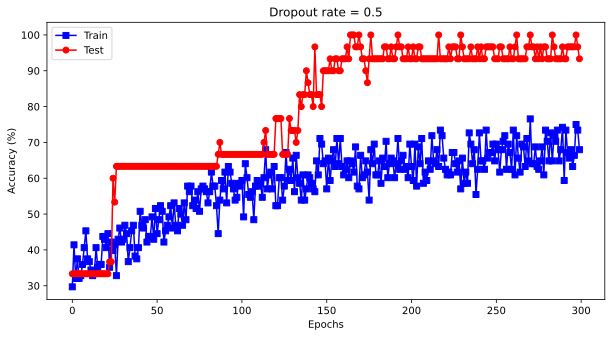

In [77]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%droprate)

plt.show()